In [ ]:
"""

REPRESENTATIVE CELL LINE 2D AND 3D SPHEROID PROPERTY ANALYSIS

"""

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import scipy.special
import cv2

import torch

import networkx as nx

import pickle
from PIL import Image, ImageDraw
import matplotlib.lines as lines
from mpl_toolkits import mplot3d
from matplotlib.lines import Line2D

from tqdm import tqdm
import glob

import statistics 

#For network adjacency checks
from skimage.transform import rotate
from sklearn.neighbors import KDTree
from scipy.spatial import distance

#For PCA
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import pandas as pd

import warnings

np.seterr(all='raise')
scipy.special.seterr(all='raise')

from lineage_timeless import lineage_timeless
from network_object import network_object
from cell_object import cell_object

In [5]:
globalpath = "/Volumes/TC_backup/Comprehensive"

lineage_list = []

selected_list = ['YM_0','YM_5.3','YM_6.3','YM_12.1','YM_13.3','YMR_0','YMR_pre7','YMR_pre14','YMR_pre21','YMR_15.4']

for lineage_path in tqdm(sorted(glob.glob(globalpath+"/*.lineage")), position=0, leave=True, desc = globalpath):
    if any(x in lineage_path for x in selected_list):   
        templineage = lineage_timeless(lineage_path[0:-8], lineage_path[0:-8], read=False)
        templineage.load_object(fin = lineage_path)
        if len(templineage.items) > 10:
            lineage_list.append(templineage)

print(len(lineage_list))

/Volumes/TC_backup/Comprehensive: 100%|██████████| 203/203 [00:24<00:00,  8.39it/s]

10


In [6]:
#for comprehensive lineages (?)

lineage_list = [lineage for lineage in lineage_list if len(lineage.items)>0]
for lineage in lineage_list:
    lineage.tag = lineage.tag[35:]
print([lin.tag for lin in lineage_list])

['YMR_0', 'YMR_15.4', 'YMR_pre14', 'YMR_pre21', 'YMR_pre7', 'YM_0', 'YM_12.1', 'YM_13.3', 'YM_5.3', 'YM_6.3']


In [7]:
def color_picker(tag):
    color = "k"
    alpha = 0.1
    if "YM_" in tag:
        color = "magenta" #ym scc magenta
        alpha = 0.1
    if "YMR_" in tag:
        color = "cyan" #ymr scc cyan
        alpha = 0.1
    if "YM_0" in tag:
        color = "red" #ym parental red
        alpha = 0.5
    if "YMR_0" in tag:
        color = "blue" #ymr parental blue
        alpha = 0.5
    #if "YM_pre" in tag:
    #    color = "orange" #ymn prelines n/a
    #    alpha = 0.05
    #if "YMR_pre" in tag:
    #    color = "navy"
    #    alpha = 0.05
    return color,alpha


import matplotlib.font_manager as fm# Collect all the font names available to matplotlib
#font_names = [f.name for f in fm.fontManager.ttflist]
#print(font_names)

plt.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titlesize"] = 24
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["lines.markersize"] = 4
#plt.rcParams["lines.linewidth"] = 10
#plt.rcParams[""]


sns.set_style("white")

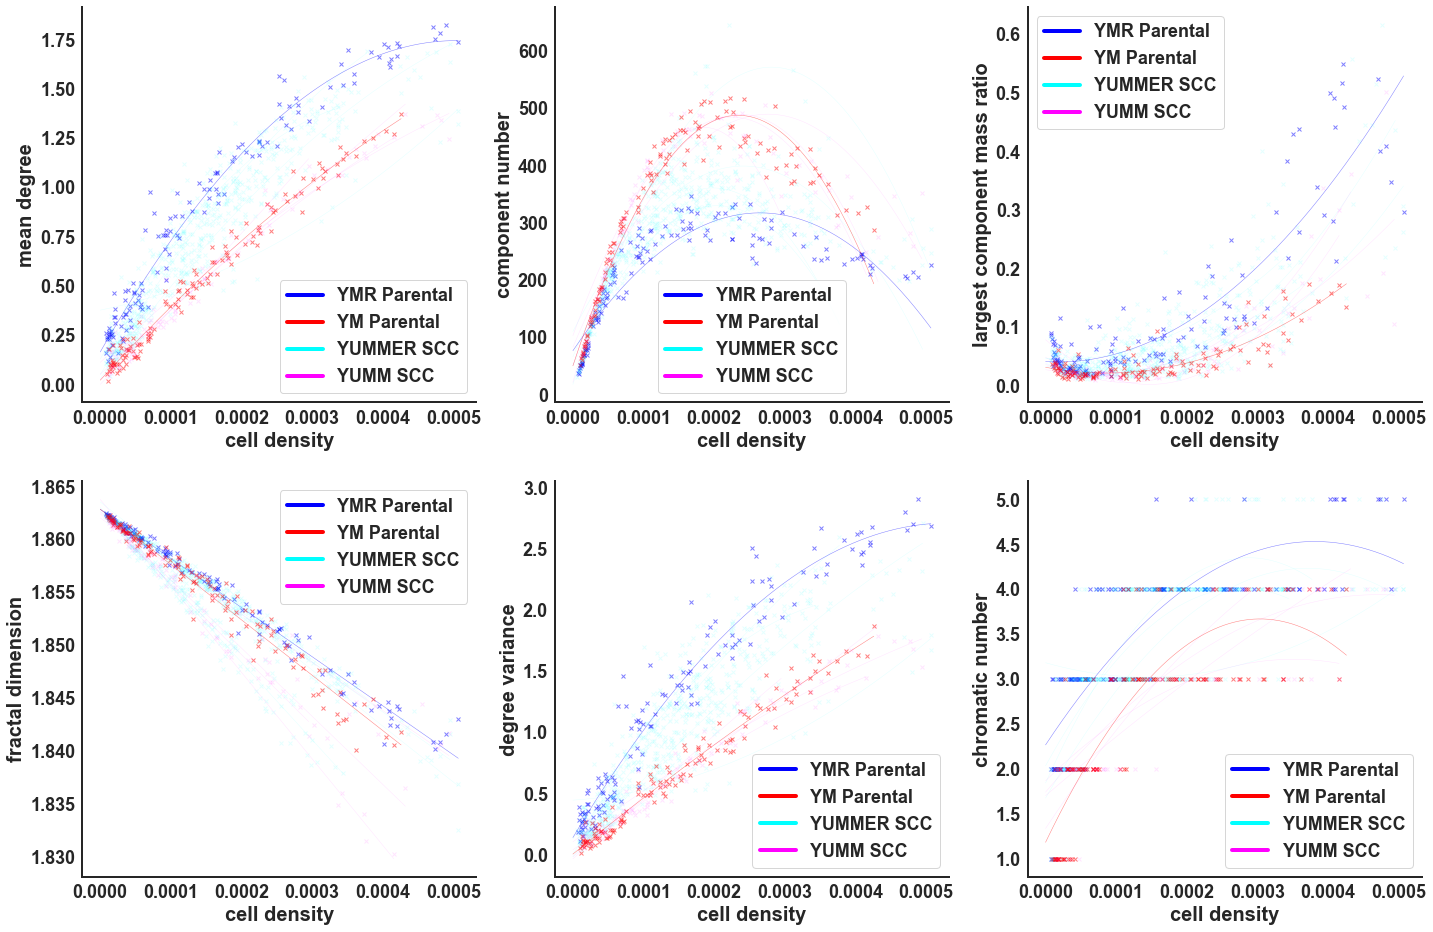

In [8]:
#//  NETWORK PROPS  //#

import itertools

plot = True

#if plot != False:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 16))
#symbols = ['.','x','+','^','s','>']
symbols = ['x']

#fitprops = []
ncomp0 = []
ncomp1 = []
ncomp2 = []
mdeg0 = []
mdeg1 = []
mdeg2 = []
mcompmass0 = []
mcompmass1 = []
mcompmass2 = []
fdim0 = []
fdim1 = []
cnum0 = []
cnum1 = []
cnum2 = []
degvar0 = []
degvar1 = []
degvar2 = []

temp = [0,0,0,0] #temporary
color = "c"
alpha = 1


legend_elements = [Line2D([0], [0], color='blue', lw=4, label='YMR Parental'),
                    Line2D([0], [0], color='red', lw=4, label='YM Parental'),
                    Line2D([0], [0], color='cyan', lw=4, label='YUMMER SCC'),
                    Line2D([0], [0], color='magenta', lw=4, label='YUMM SCC'),]

def polyfit_rough(xdata,ydata,pdegree = 1, plot = False, axes = None, color = None, label = "Fit function", alpha = 0.2):
    popt = np.polyfit(xdata, ydata, pdegree)#---------------------------------
    if plot != False:
        t = np.linspace(0, max(xdata), 1000)
        axes.plot(t, np.poly1d(popt)(t), label=label, color = color, linewidth = .5, alpha = alpha)
        # Hide the top and right spines of the axis
        axes.spines['right'].set_visible(False)
        axes.spines['top'].set_visible(False)
        axes.set_xlabel("cell density")
        axes.legend(handles=legend_elements)
    return popt

i = 0
#ax1.set_title("mean degree")
ax1.set_ylabel("mean degree")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    degree = [network.average_degree() for network in lineage.items]

    degree = [degree for _,degree in sorted(zip(density,degree))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)
    ax1.plot(density,degree, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,degree,pdegree=2,axes = ax1, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    mdeg0.append(temp[0])
    mdeg1.append(temp[1])
    mdeg2.append(temp[2])
    i += 1

i = 0
#ax2.set_title("component number")
ax2.set_ylabel("component number")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    num_components = [network.num_components for network in lineage.items]

    num_components = [num_components for _,num_components in sorted(zip(density,num_components))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)
    ax2.plot(density,num_components, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,num_components,pdegree=2,axes = ax2, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    ncomp0.append(temp[0])
    ncomp1.append(temp[1])
    ncomp2.append(temp[2])
    i += 1

i = 0
#ax3.set_title("largest component mass ratio")
ax3.set_ylabel("largest component mass ratio")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    cellnum = [network.number for network in lineage.items]
    max_mass = [network.get_max_comp_mass() for network in lineage.items]

    max_mass = [max_mass for _,max_mass in sorted(zip(density,max_mass))]
    cellnum = sorted(cellnum)
    density = sorted(density)
    
    max_mass = np.divide(max_mass,cellnum)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)

    ax3.plot(density,max_mass, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,max_mass,pdegree=2,axes = ax3, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    mcompmass0.append(temp[0])
    mcompmass1.append(temp[1])
    mcompmass2.append(temp[2])
    i += 1

i = 0
#ax4.set_title("fractal dimension")
ax4.set_ylabel("fractal dimension")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    fractal_dim = [network.fractal_dim for network in lineage.items]

    fractal_dim = [fractal_dim for _,fractal_dim in sorted(zip(density,fractal_dim))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)

    ax4.plot(density,fractal_dim, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,fractal_dim,pdegree=1,axes = ax4, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    fdim0.append(temp[0])
    fdim1.append(temp[1])
    i += 1


i = 0
#ax5.set_title("degree variance")
ax5.set_ylabel("degree variance")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    degree_var = [network.degree_variance() for network in lineage.items]

    degree_var = [degree_var for _,degree_var in sorted(zip(density,degree_var))]
    density = sorted(density)
    
    #degree_var = np.divide(degree_var,density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)

    ax5.plot(density,degree_var, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,degree_var,pdegree=2,axes = ax5, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    degvar0.append(temp[0])
    degvar1.append(temp[1])
    degvar2.append(temp[2])
    i += 1

i = 0
#ax6.set_title("chromatic number")
ax6.set_ylabel("chromatic number")
for lineage in lineage_list:
    #tqdm(lineage_list, desc = "chromatic number", position=0, leave=True):
    density = [network.density for network in lineage.items]
    colornum = [network.calc_chromatic() for network in lineage.items]

    colornum = [colornum for _,colornum in sorted(zip(density,colornum))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)

    ax6.plot(density,colornum, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,colornum,pdegree=2,axes = ax6, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    cnum0.append(temp[0])
    cnum1.append(temp[1])
    cnum2.append(temp[2])
    i += 1

#plt.savefig("NetworkPropertyPlots.svg", format="svg")

/Users/trevorchan/environments/machine-learning/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/trevorchan/environments/machine-learning/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/trevorchan/environments/machine-learning/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/trevorchan/environments/machine-learning/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWar

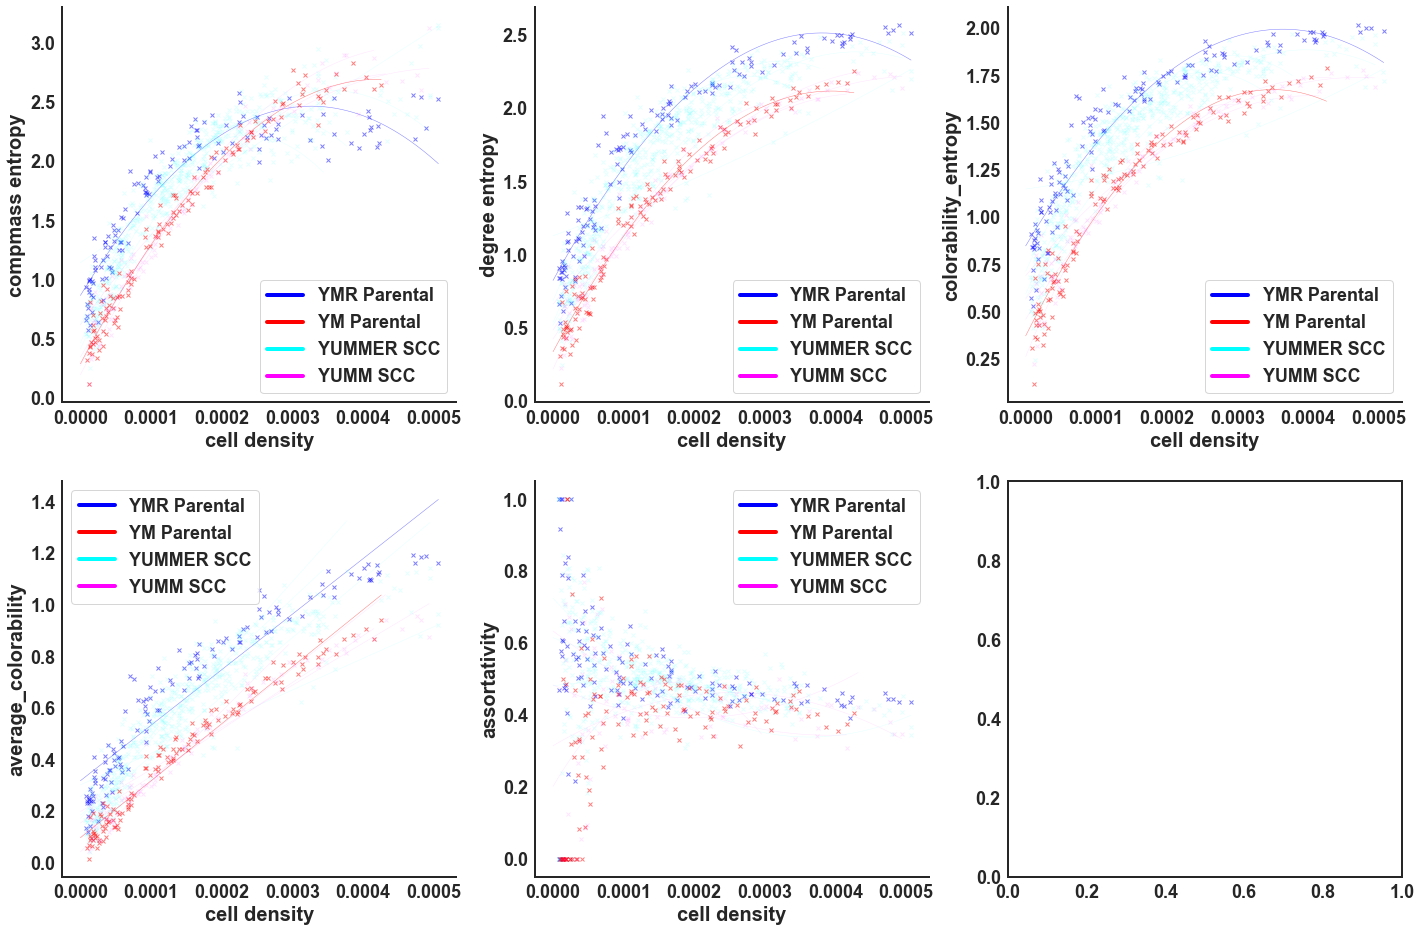

In [9]:
#//  NETWORK PROPS 2 -- Entropy and assortativity //#

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 16))


compmasse0 = []
compmasse1 = []
compmasse2 = []
dege0 = []
dege1 = []
dege2 = []
colore0 = []
colore1 = []
colore2 = []
avgcolor0 = []
avgcolor1 = []
assortativity0 = []


i = 0
#ax1.set_title("mean degree")
ax1.set_ylabel("compmass entropy")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    compmass_e = [network.compmass_entropy() for network in lineage.items]

    compmass_e = [compmass_e for _,compmass_e in sorted(zip(density,compmass_e))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)
    ax1.plot(density,compmass_e, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,compmass_e,pdegree=2,axes = ax1, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    compmasse0.append(temp[0])
    compmasse1.append(temp[1])
    compmasse2.append(temp[2])
    i += 1

i = 0
#ax2.set_title("component number")
ax2.set_ylabel("degree entropy")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    deg_e = [network.degree_entropy() for network in lineage.items]

    deg_e = [deg_e for _,deg_e in sorted(zip(density,deg_e))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)
    ax2.plot(density,deg_e, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,deg_e,pdegree=2,axes = ax2, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    dege0.append(temp[0])
    dege1.append(temp[1])
    dege2.append(temp[2])
    i += 1

i = 0
#ax3.set_title("largest component mass ratio")
ax3.set_ylabel("colorability_entropy")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    color_e = [network.colorability_entropy() for network in lineage.items]

    color_e = [color_e for _,color_e in sorted(zip(density,color_e))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)

    ax3.plot(density,color_e, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,color_e,pdegree=2,axes = ax3, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    colore0.append(temp[0])
    colore1.append(temp[1])
    colore2.append(temp[2])
    i += 1

i = 0
#ax4.set_title("fractal dimension")
ax4.set_ylabel("average_colorability")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    avg_color = [network.calc_avg_chromatic() for network in lineage.items]

    avg_color = [avg_color for _,avg_color in sorted(zip(density,avg_color))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)

    ax4.plot(density,avg_color, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,avg_color,pdegree=1,axes = ax4, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    avgcolor0.append(temp[0])
    avgcolor1.append(temp[1])
    i += 1


i = 0
#ax5.set_title("degree variance")
ax5.set_ylabel("assortativity")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    assortativity = [network.assortativity() for network in lineage.items]

    assortativity = [assortativity for _,assortativity in sorted(zip(density,assortativity))]
    density = sorted(density)
    
    #degree_var = np.divide(degree_var,density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)

    ax5.plot(density,assortativity, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,assortativity,pdegree=2,axes = ax5, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    assortativity0.append(temp[0])
    i += 1


    
'''i = 0
#ax6.set_title("chromatic number")
ax6.set_ylabel("chromatic number")
for lineage in lineage_list:
    #tqdm(lineage_list, desc = "chromatic number", position=0, leave=True):
    density = [network.density for network in lineage.items]
    colornum = [network.calc_chromatic() for network in lineage.items]

    colornum = [colornum for _,colornum in sorted(zip(density,colornum))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)

    ax6.plot(density,colornum, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,colornum,pdegree=2,axes = ax6, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    cnum0.append(temp[0])
    cnum1.append(temp[1])
    cnum2.append(temp[2])
    i += 1
'''

#plt.savefig("NetworkPropertyPlots.svg", format="svg")

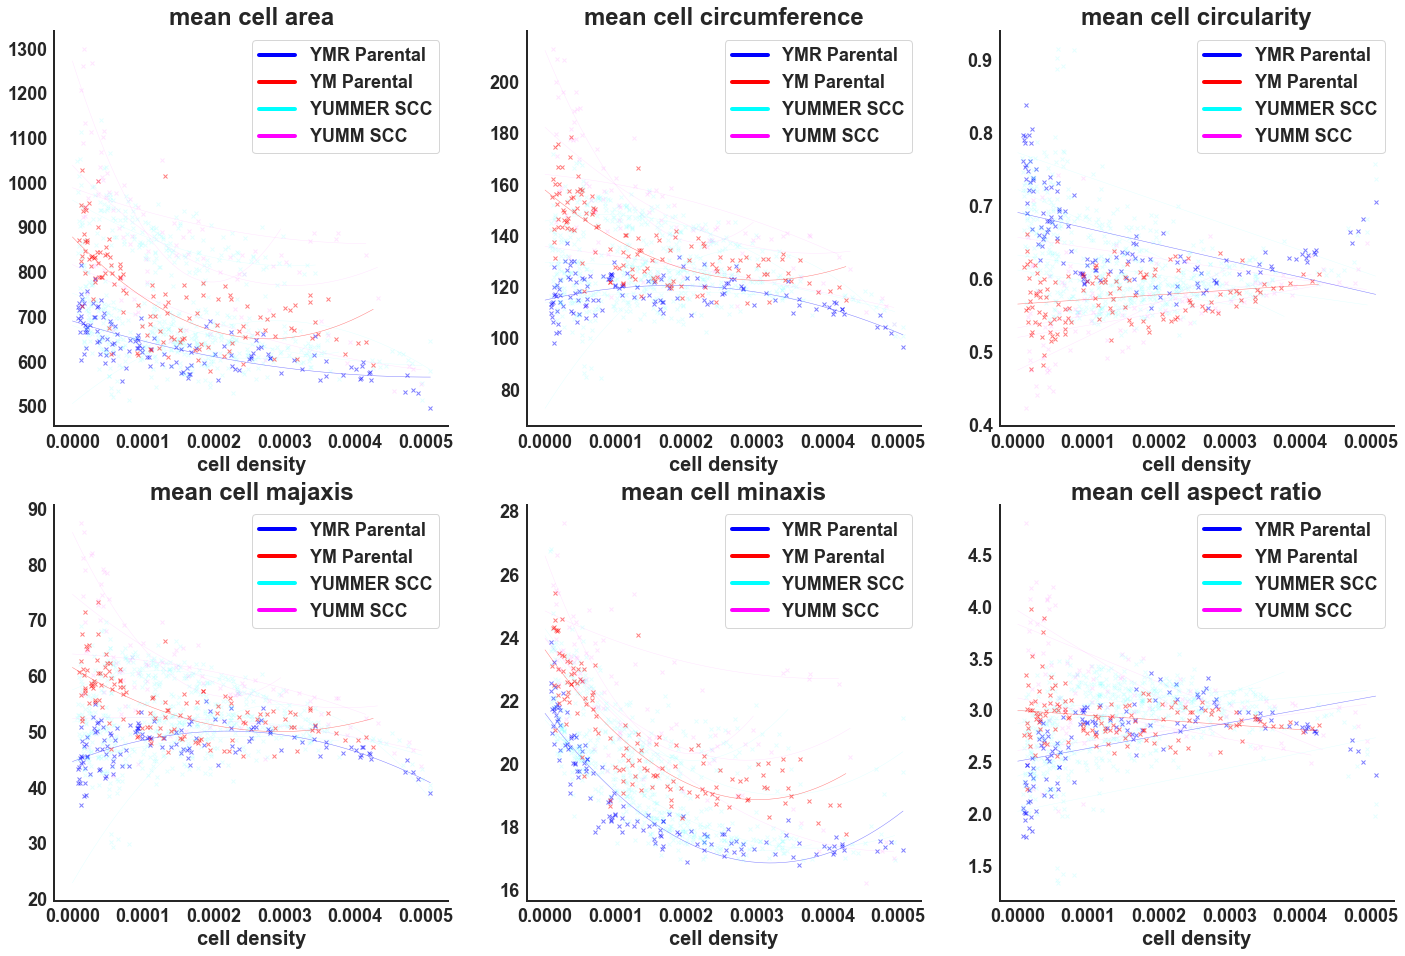

In [10]:
#//  SINGLE CELL PROPS  //#

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 16))

plot = True

#area_l = np.empty(0)
#area_h = np.empty(0)
area0 = np.empty(0)
area1 = np.empty(0)
area2 = np.empty(0)
#circum_l = np.empty(0)
#circum_h = np.empty(0)
circum0 = np.empty(0)
circum1 = np.empty(0)
circum2 = np.empty(0)
circ0 = np.empty(0)
circ1 = np.empty(0)
asra0 = np.empty(0)
asra1 = np.empty(0)

temp = [0,0,0,0] #temporary


#avg = lambda x: sum(x)/len(x)
def avg(x):
    if type(x) is list:
        return sum(x)/len(x)
    return x


i = 0
ax1.set_title("mean cell area")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    area = [avg(network.cell_areas) for network in lineage.items]

    area = [area for _,area in sorted(zip(density,area))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)

    ax1.plot(density,area, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,area,pdegree=2,axes = ax1, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    area0 = np.append(area0,temp[0])
    area1 = np.append(area1,temp[1])
    area2 = np.append(area2,temp[2])
    i += 1

i = 0
ax2.set_title("mean cell circumference")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    circum = [avg(network.cell_perimeters) for network in lineage.items]

    circum = [circum for _,circum in sorted(zip(density,circum))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)

    ax2.plot(density,circum, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,circum,pdegree=2,axes = ax2, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    circum0 = np.append(circum0,temp[0])
    circum1 = np.append(circum1,temp[1])
    circum2 = np.append(circum2,temp[2])
    i += 1

i = 0
ax3.set_title("mean cell circularity")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    circul = [avg(network.cell_circularities) for network in lineage.items]

    circul = [circul for _,circul in sorted(zip(density,circul))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)

    ax3.plot(density,circul, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,circul,pdegree=1,axes = ax3, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    circ0 = np.append(circ0,temp[0])
    circ1 = np.append(circ1,temp[1])
    i += 1

i = 0
ax4.set_title("mean cell majaxis")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    majax = [avg(network.cell_majaxes) for network in lineage.items]

    majax = [majax for _,majax in sorted(zip(density,majax))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)

    ax4.plot(density,majax, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,majax,pdegree=2,axes = ax4, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    i += 1

i = 0
ax5.set_title("mean cell minaxis")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    minax = [avg(network.cell_minaxes) for network in lineage.items]

    minax = [minax for _,minax in sorted(zip(density,minax))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)

    ax5.plot(density,minax, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,minax,pdegree=2,axes = ax5, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    i += 1

i = 0
ax6.set_title("mean cell aspect ratio")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    
    asra = [avg(network.asra) for network in lineage.items]
    asra = [asra for _,asra in sorted(zip(density,asra))]

    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)

    ax6.plot(density,asra, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,asra,pdegree=1,axes = ax6, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    asra0 = np.append(asra0,temp[0])
    asra1 = np.append(asra1,temp[1])
    np.append(asra1,temp[1])
    i += 1
#plt.savefig("SingleCellProps_densityPlots_YM+YMR.png", dpi = 75)

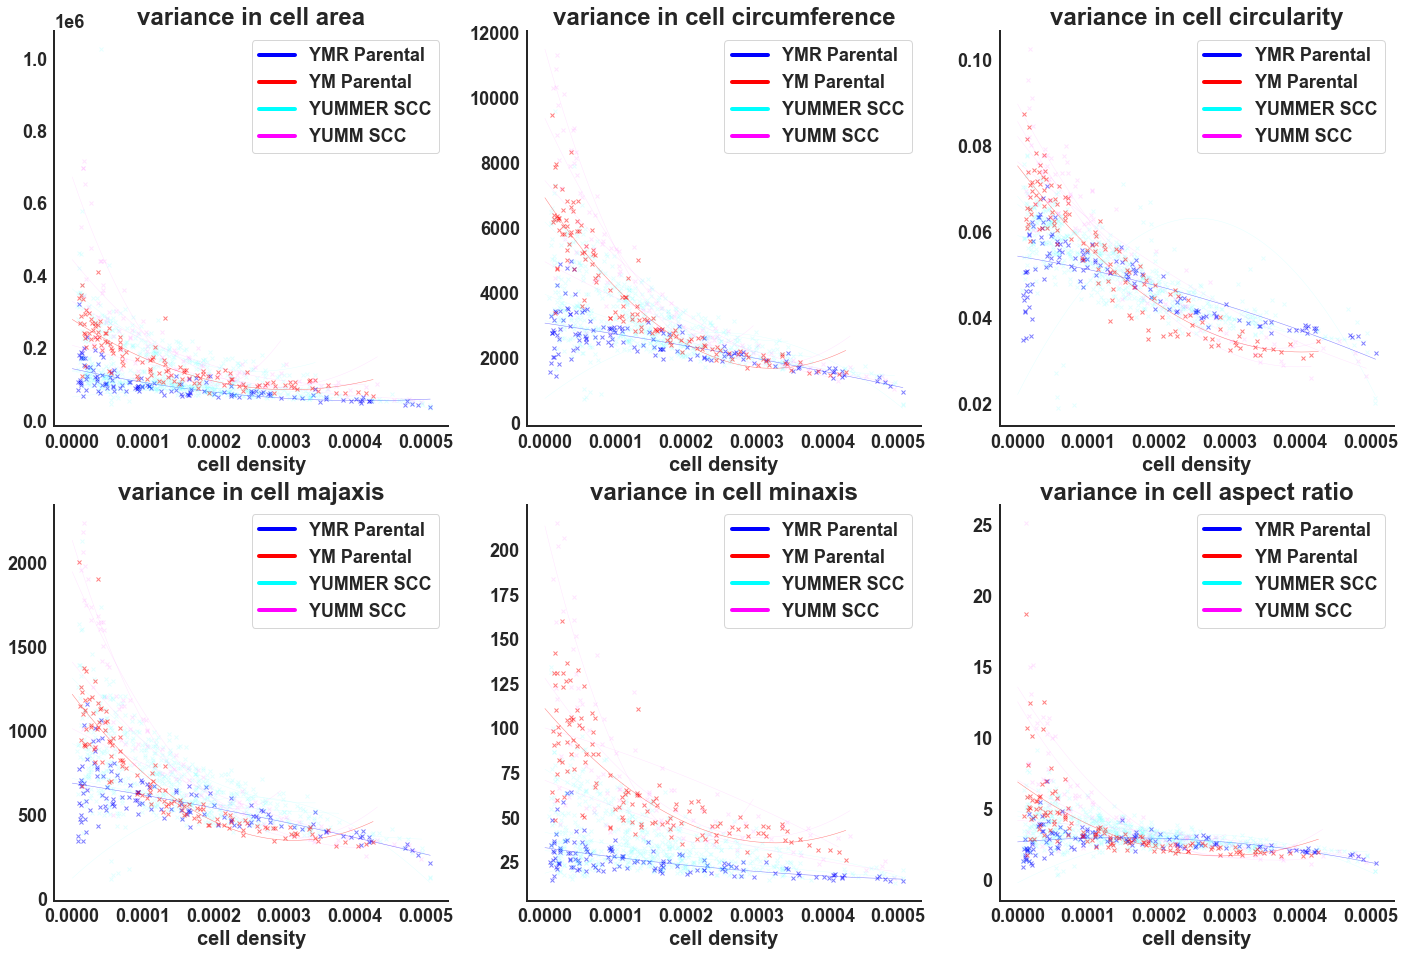

In [11]:
#//  SINGLE CELL VARIANCE PROPS  //#

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 16))

plot = True

areavar0 = np.empty(0)
areavar1 = np.empty(0)
areavar2 = np.empty(0)
circumvar0 = np.empty(0)
circumvar1 = np.empty(0)
circumvar2 = np.empty(0)
circvar0 = np.empty(0)
circvar1 = np.empty(0)
circvar2 = np.empty(0)
asravar0 = np.empty(0)
asravar1 = np.empty(0)
asravar2 = np.empty(0)

temp = [0,0,0,0] #temporary


#avg = lambda x: sum(x)/len(x)
def avg(x):
    if type(x) is list:
        return sum(x)/len(x)
    return x


i = 0
ax1.set_title("variance in cell area")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    area = [avg(network.cell_areas_var) for network in lineage.items]

    area = [area for _,area in sorted(zip(density,area))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)

    ax1.plot(density,area, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,area,pdegree=2,axes = ax1, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    areavar0 = np.append(areavar0,temp[0])
    areavar1 = np.append(areavar1,temp[1])
    areavar2 = np.append(areavar2,temp[2])
    i += 1

i = 0
ax2.set_title("variance in cell circumference")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    circum = [avg(network.cell_perimeters_var) for network in lineage.items]

    circum = [circum for _,circum in sorted(zip(density,circum))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)

    ax2.plot(density,circum, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,circum,pdegree=2,axes = ax2, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    circumvar0 = np.append(circumvar0,temp[0])
    circumvar1 = np.append(circumvar1,temp[1])
    circumvar2 = np.append(circumvar2,temp[2])
    i += 1

i = 0
ax3.set_title("variance in cell circularity")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    circul = [avg(network.cell_circularities_var) for network in lineage.items]

    circul = [circul for _,circul in sorted(zip(density,circul))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)

    ax3.plot(density,circul, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,circul,pdegree=2,axes = ax3, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    circvar0 = np.append(circvar0,temp[0])
    circvar1 = np.append(circvar1,temp[1])
    circvar2 = np.append(circvar2,temp[2])
    i += 1

i = 0
ax4.set_title("variance in cell majaxis")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    majax = [avg(network.cell_majaxes_var) for network in lineage.items]

    majax = [majax for _,majax in sorted(zip(density,majax))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)

    ax4.plot(density,majax, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,majax,pdegree=2,axes = ax4, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    i += 1

i = 0
ax5.set_title("variance in cell minaxis")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    minax = [avg(network.cell_minaxes_var) for network in lineage.items]

    minax = [minax for _,minax in sorted(zip(density,minax))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)

    ax5.plot(density,minax, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,minax,pdegree=2,axes = ax5, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    i += 1

i = 0
ax6.set_title("variance in cell aspect ratio")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    
    asra = [avg(network.asra_var) for network in lineage.items]
    asra = [asra for _,asra in sorted(zip(density,asra))]

    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color,alpha = color_picker(lineage.tag)

    ax6.plot(density,asra, symbols[i%len(symbols)], label = lineage.tag, color = color, alpha = alpha)
    
    temp = polyfit_rough(density,asra,pdegree=2,axes = ax6, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    asravar0 = np.append(asravar0,temp[0])
    asravar1 = np.append(asravar1,temp[1])
    asravar2 = np.append(asravar2,temp[2])
    np.append(asra1,temp[1])
    i += 1
#plt.savefig("SingleCellPropsVariance_densityPlots_YM+YMR.png", dpi = 75)

In [12]:
#///   LOAD TO PANDAS DF   ///#


'''
each lineage has:

lineage

3 fit params for num components:
    ncomp0 ncomp1 ncomp2
    
2 fit params for mean degree (normalized):
    mdeg0 mdeg1
    
3 fit params for max comp mass (normalized):
    mcompmass0 mcompmass1 mcompmass2
    
2 fit params for fractal dimension:
    fdim0 fdim1
    
2 fit params for chromatic number:
    cnum0 cnum1
    
2 fit params for degree variance:
    degvar0 degvar1
    
'''

#Creating the dataframe

l_tags = [lineage.tag for lineage in lineage_list]


objs = {
    'lineage':l_tags,
    'ncomp0':ncomp0,
    'ncomp1':ncomp1, 
    'ncomp2':ncomp2, 
    'mdeg0':mdeg0, 
    'mdeg1':mdeg1, 
    'mcompmass0':mcompmass0, 
    'mcompmass1':mcompmass1, 
    'mcompmass2':mcompmass2, 
    'fdim0':fdim0, 
    'fdim1':fdim1, 
    'cnum0':cnum0, 
    'cnum1':cnum1, 
    'degvar0':degvar0, 
    'degvar1':degvar1,
}

'''
Additional OBJS:
'''
ncomp0 = np.array(ncomp0)
ncomp1 = np.array(ncomp1)
ncomp2 = np.array(ncomp2)
mdeg0 = np.array(mdeg0)
mdeg1 = np.array(mdeg1)
mdeg2 = np.array(mdeg2)
mcompmass0 = np.array(mcompmass0)
mcompmass1 = np.array(mcompmass1)
mcompmass2 = np.array(mcompmass2)
fdim0 = np.array(fdim0)
cnum0 = np.array(cnum0)
cnum1 = np.array(cnum1)
cnum2 = np.array(cnum2)

compmasse0 = np.array(compmasse0)
compmasse1 = np.array(compmasse1)
compmasse2 = np.array(compmasse2)
dege0 = np.array(dege0)
dege1 = np.array(dege1)
dege2 = np.array(dege2)
colore0 = np.array(colore0)
colore1 = np.array(colore1)
colore2 = np.array(colore2)
avgcolor0 = np.array(avgcolor0)
avgcolor1 = np.array(avgcolor1)
assortativity0 = np.array(assortativity0)

#area_l = []
#area_h = []
#circum_l = []
#circum_h = []
#circ0
#circ1
#asra0
#asra1

hdensity = 0.0004
ldensity = 0.00015

#cell area low density, high density:
area_l = area0*ldensity*ldensity+area1*ldensity+area2
area_h = area0*hdensity*hdensity+area1*hdensity+area2

#cell circumference low density, high density:
circum_l = circum0*ldensity*ldensity+circum1*ldensity+circum2
circum_h = circum0*hdensity*hdensity+circum1*hdensity+circum2

#num components apex:
ncomph = -ncomp1/(2*ncomp0)                       #x coord of vertex
ncompk = ncomp2 - (ncomp1*ncomp1/(4*ncomp0))      #y coord of vertex

#(relative) max component mass:
mcompmass_h = mcompmass0*(hdensity*hdensity)+mcompmass1*(hdensity)+mcompmass2  #y value calculated at x=0.0004
mcompmass_d = 2*mcompmass0*(hdensity)+mcompmass1                           #y' value calculated at x=0.0004
    
#fractal dimension:
fdim0  #slope only, constant not needed as all converge to same value with very few objects
    
#mean degree / degree variance:
  #as K-degree and variance in degree are highly correlated, and likely simply scale linearly, here omit degvar
mdeg_l = mdeg0*(ldensity*ldensity)+mdeg1*(ldensity)+mdeg2  #y value calculated at x=0.00015
dmdeg_l = 2*mdeg0*(ldensity)+mdeg1                      #y' value calculated at x=0.0004
mdeg_h = mdeg0*(hdensity*hdensity)+mdeg1*(hdensity)+mdeg2     #y value calculated at x=0.00015
dmdeg_h = 2*mdeg0*(hdensity)+mdeg1                       #y' value calculated at x=0.0004
    
#chromatic number:
cnumh = -cnum1/(2*cnum0)                    #x coord of vertex
cnumk = cnum2 - (cnum1*cnum1/(4*cnum0))     #y coord of vertex




#-----------------------------------------------------------------------add in new network properties-------------------------------------------------------------------------









#for single cell morphological variance, all properties are calculated at density of 0.0001
areavar = areavar0*(0.0001*0.0001)+areavar1*0.0001+areavar2
circumvar = circumvar0*(0.0001*0.0001)+circumvar1*0.0001+circumvar2
circvar = circvar0*(0.0001*0.0001)+circvar1*0.0001+circvar2
asravar = asravar0*(0.0001*0.0001)+asravar1*0.0001+asravar2

add_objs = {
    #network properties
    'lineage':l_tags,
    'ncomph':ncomph,
    'ncompk':ncompk, 
    'mdeg_l':mdeg_l, 
    'dmdeg_l':dmdeg_l,
    'mdeg_h':mdeg_h, 
    'dmdeg_h':dmdeg_h,
    'mcompmass_h':mcompmass_h, 
    'mcompmass_d':mcompmass_d, 
    'fdim0':fdim0, 
    'cnumh':cnumh, 
    'cnumk':cnumk, 
    #new network properties
    #-----------------------------------------------------------------------add in new network properties-------------------------------------------------------------------------
    
    
    
    #cell properties
    'area_l':area_l,
    'area_h':area_h,
    'circum_l':circum_l,
    'circum_h':circum_h,
    'circ0':circ0,
    'circ1':circ1,
    'asra0':asra0,
    'asra1':asra1,
    #cell variance properties
    'areavar':areavar,
    'circumvar':circumvar,
    'circvar':circvar,
    'asravar':asravar,
}

#df = pd.DataFrame(objs)
df_2d = pd.DataFrame(add_objs)

df_3d = pd.read_csv('averages_out.csv')
df_3d.rename(columns = {'Unnamed: 0':'lineage'}, inplace=True)


#df.to_pickle('comprehensive_df_pickle.data')

In [13]:
df_2d.sort_values('lineage',axis = 0)

,lineage,ncomph,ncompk,mdeg_l,dmdeg_l,mdeg_h,dmdeg_h,mcompmass_h,mcompmass_d,fdim0,...,circum_l,circum_h,circ0,circ1,asra0,asra1,areavar,circumvar,circvar,asravar
0,YMR_0,0.000265,317.067692,0.965448,4403.204273,1.677181,1290.663113,0.338637,1559.095161,-46.424112,...,120.433917,111.831866,-221.192272,0.691047,1240.789120,2.506929,105572.384589,2721.848326,0.051278,2.928099
1,YMR_15.4,0.000281,571.434528,0.543038,1487.380752,1.073627,2757.331986,0.185840,1219.610116,-52.987716,...,120.767523,125.379430,-333.252630,0.772821,1403.523140,2.022457,81669.327025,2057.638985,0.048207,1.858638
2,YMR_pre14,0.000199,360.521459,0.852994,4672.981358,1.737232,2400.925973,0.205723,988.732180,-47.498236,...,117.835578,113.660677,-460.217682,0.722475,2668.622172,2.362180,106008.323081,2735.598432,0.054471,2.947964
3,YMR_pre21,0.000205,329.587258,0.917447,4071.018465,1.441434,120.872659,0.294184,1332.955054,-73.180625,...,146.853628,114.801020,-156.904030,0.612198,664.100422,2.988173,221637.116646,4329.195319,0.052188,4.276934
4,YMR_pre7,0.000241,398.804453,0.706817,4044.764939,1.519196,2454.265066,0.274707,1624.223674,-47.351422,...,127.538760,116.880568,-137.868840,0.632649,640.951732,2.873020,111628.173502,3142.281069,0.055212,3.691060
5,YM_0,0.000234,487.328138,0.565565,3347.218030,1.286492,2420.199659,0.151698,828.381769,-52.329489,...,131.760209,125.864324,63.727659,0.565648,-462.658640,2.997245,173552.985328,4162.365995,0.056557,3.906577
6,YM_12.1,0.000238,488.849787,0.541785,3214.886267,1.324655,3048.074227,0.268256,1846.350973,-64.430808,...,151.319630,133.214087,166.745090,0.520061,-2808.673604,3.830058,243267.157986,5384.540927,0.063018,7.003754
7,YM_13.3,0.000276,489.350392,0.583628,2888.971378,1.198919,2033.357754,0.181150,960.998168,-45.494960,...,129.919504,117.519498,-144.694992,0.656955,903.116098,2.611044,159174.586433,3846.547069,0.063267,3.808128
8,YM_5.3,0.000186,466.287481,0.571312,3881.711694,1.572946,4131.358914,0.250129,1508.668645,-66.620311,...,145.083346,185.269916,464.985817,0.475279,-4208.927925,3.962175,243011.895535,5357.833379,0.062944,5.868643
9,YM_6.3,0.000225,484.276461,0.538428,3162.879875,1.216303,2260.117974,0.227880,1782.868142,-81.746482,...,157.305075,134.550159,175.482974,0.533123,-1327.526869,3.117124,224329.512257,5121.906743,0.060523,4.375295


In [14]:
df_3d.sort_values('lineage',axis=0)

,lineage,area,perimeter,circularity,aspect_ratio,roundness,solidity,protrusion_num,protrusion_mean_len,protrusion_max_len,discr_num,discr_mean_dist,discr_max_dist,discr_mean_area
4,YMR_0,0.006377,2.659420,0.011331,1.145573,0.875926,0.495210,69.000000,0.056984,0.075393,51.888889,0.060990,0.116991,0.000004
1,YMR_15.4,0.005994,2.931861,0.009639,1.115540,0.900042,0.427472,75.444444,0.056518,0.077948,73.777778,0.059275,0.101080,0.000004
0,YMR_pre14,0.005736,2.599380,0.010767,1.128865,0.886418,0.453270,70.000000,0.055635,0.081669,56.666667,0.065159,0.112963,0.000004
2,YMR_pre21,0.003418,1.558903,0.023027,1.238818,0.817761,0.423022,38.500000,0.044842,0.062535,33.125000,0.045189,0.085517,0.000004
3,YMR_pre7,0.004534,2.393612,0.010505,1.055381,0.947304,0.363045,39.500000,0.056011,0.077549,88.000000,0.059500,0.125714,0.000005
9,YM_0,0.002538,1.530656,0.014060,1.254021,0.811699,0.488486,51.625000,0.036880,0.049861,73.000000,0.045743,0.083156,0.000003
5,YM_12.1,0.000983,0.672611,0.035300,1.382806,0.754824,0.324662,18.454545,0.028783,0.045857,18.272727,0.029751,0.048868,0.000002
6,YM_13.3,0.002700,1.898824,0.009738,1.169421,0.860442,0.380143,52.714286,0.040824,0.056876,86.285714,0.048324,0.087595,0.000003
7,YM_5.3,0.001606,1.183603,0.014826,1.321113,0.765834,0.399901,38.833333,0.031703,0.045429,42.333333,0.036963,0.080341,0.000003
8,YM_6.3,0.000877,0.618628,0.032557,1.285820,0.787786,0.443292,24.850000,0.024038,0.034049,8.400000,0.025996,0.039715,0.000002


In [15]:
combineddf = pd.concat([df_2d,df_3d],axis=1)
combineddf

,lineage,ncomph,ncompk,mdeg_l,dmdeg_l,mdeg_h,dmdeg_h,mcompmass_h,mcompmass_d,fdim0,...,aspect_ratio,roundness,solidity,protrusion_num,protrusion_mean_len,protrusion_max_len,discr_num,discr_mean_dist,discr_max_dist,discr_mean_area
0,YMR_0,0.000265,317.067692,0.965448,4403.204273,1.677181,1290.663113,0.338637,1559.095161,-46.424112,...,1.128865,0.886418,0.453270,70.000000,0.055635,0.081669,56.666667,0.065159,0.112963,0.000004
1,YMR_15.4,0.000281,571.434528,0.543038,1487.380752,1.073627,2757.331986,0.185840,1219.610116,-52.987716,...,1.115540,0.900042,0.427472,75.444444,0.056518,0.077948,73.777778,0.059275,0.101080,0.000004
2,YMR_pre14,0.000199,360.521459,0.852994,4672.981358,1.737232,2400.925973,0.205723,988.732180,-47.498236,...,1.238818,0.817761,0.423022,38.500000,0.044842,0.062535,33.125000,0.045189,0.085517,0.000004
3,YMR_pre21,0.000205,329.587258,0.917447,4071.018465,1.441434,120.872659,0.294184,1332.955054,-73.180625,...,1.055381,0.947304,0.363045,39.500000,0.056011,0.077549,88.000000,0.059500,0.125714,0.000005
4,YMR_pre7,0.000241,398.804453,0.706817,4044.764939,1.519196,2454.265066,0.274707,1624.223674,-47.351422,...,1.145573,0.875926,0.495210,69.000000,0.056984,0.075393,51.888889,0.060990,0.116991,0.000004
5,YM_0,0.000234,487.328138,0.565565,3347.218030,1.286492,2420.199659,0.151698,828.381769,-52.329489,...,1.382806,0.754824,0.324662,18.454545,0.028783,0.045857,18.272727,0.029751,0.048868,0.000002
6,YM_12.1,0.000238,488.849787,0.541785,3214.886267,1.324655,3048.074227,0.268256,1846.350973,-64.430808,...,1.169421,0.860442,0.380143,52.714286,0.040824,0.056876,86.285714,0.048324,0.087595,0.000003
7,YM_13.3,0.000276,489.350392,0.583628,2888.971378,1.198919,2033.357754,0.181150,960.998168,-45.494960,...,1.321113,0.765834,0.399901,38.833333,0.031703,0.045429,42.333333,0.036963,0.080341,0.000003
8,YM_5.3,0.000186,466.287481,0.571312,3881.711694,1.572946,4131.358914,0.250129,1508.668645,-66.620311,...,1.285820,0.787786,0.443292,24.850000,0.024038,0.034049,8.400000,0.025996,0.039715,0.000002
9,YM_6.3,0.000225,484.276461,0.538428,3162.879875,1.216303,2260.117974,0.227880,1782.868142,-81.746482,...,1.254021,0.811699,0.488486,51.625000,0.036880,0.049861,73.000000,0.045743,0.083156,0.000003


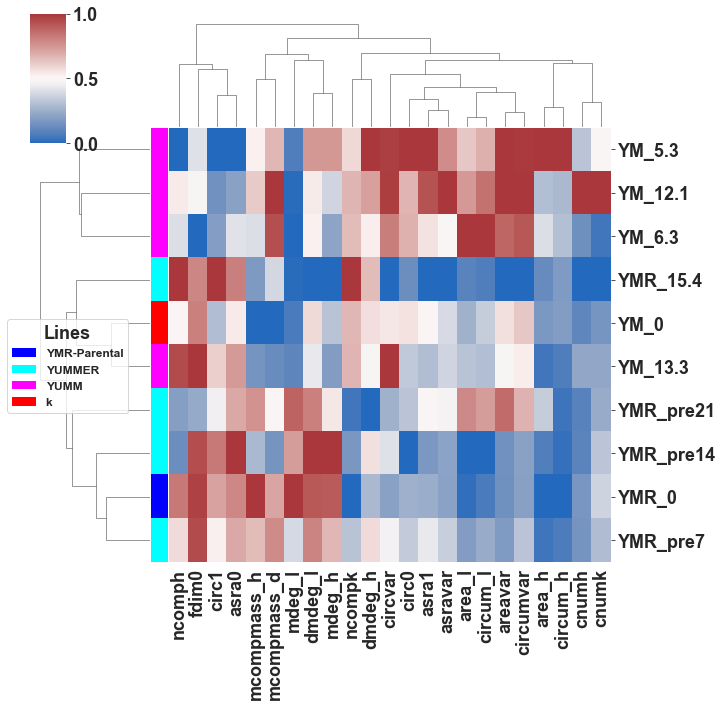

In [18]:
#Hierarchical heatmap clustering:
#Outlier exclusion based on Z-Score Thresholding:

from scipy import stats
#sns.set_theme(color_codes=False)
sns.color_palette("coolwarm", as_cmap=True)

#testdf = df.copy(deep=True)
testdf = df_2d.copy(deep=True)

lineages = testdf.pop('lineage')
#testdf.pop('line')
#z = np.abs(stats.zscore(testdf))

#threshold = 4
#dropindices = list(dict.fromkeys(np.where(z>threshold)[0].tolist()))
#dropindices = dropindices + [108,125,128,6] #added lineages manually checked and discarded
#print(dropindices)
#testdf = testdf.drop(dropindices)
#lineages = lineages.drop(dropindices)
row_colors = [color_picker(lineage[0])[0] for lineage in df_2d.loc[:,['lineage']].values]
#dropindices.sort(reverse=True)
#for index in dropindices:
#    del row_colors[index]

g = sns.clustermap(testdf,standard_scale=1,row_colors=row_colors, xticklabels=True,  
                   figsize = (10,10), cmap="vlag",yticklabels=lineages,)


labeler = lambda label : 'YUMMER' if label=='cyan' or label=='navy' else ('YUMM' if label=='magenta' 
                        else ('YMR-Parental' if label=='blue' else('YM-Parental' if label=='yellow' else 'k')))
for label in np.unique(np.array(row_colors)):
    g.ax_col_dendrogram.bar(0, 0, color=label, label=labeler(label), linewidth=0)
l1 = g.ax_col_dendrogram.legend(title='Lines', loc="center", ncol=1,
            bbox_to_anchor=(-0.23, -2.2),prop={'size': 12})

#plt.title("hierarchical heatmap clustering YM+YMR SCC",loc="center")
plt.savefig("figure_outputs/hierarchical_heatmap_clustering.svg", format="svg")


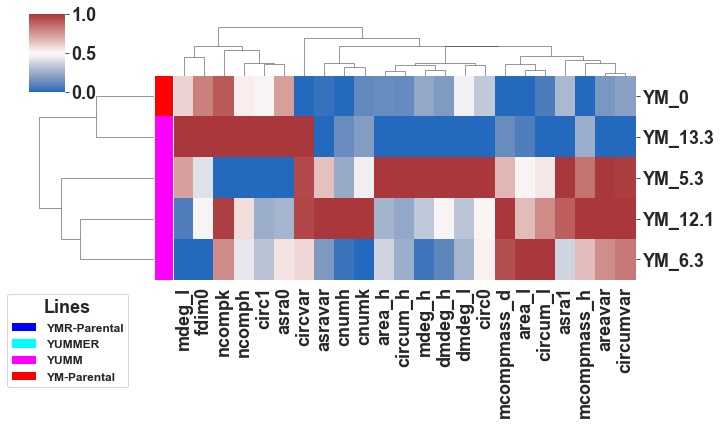

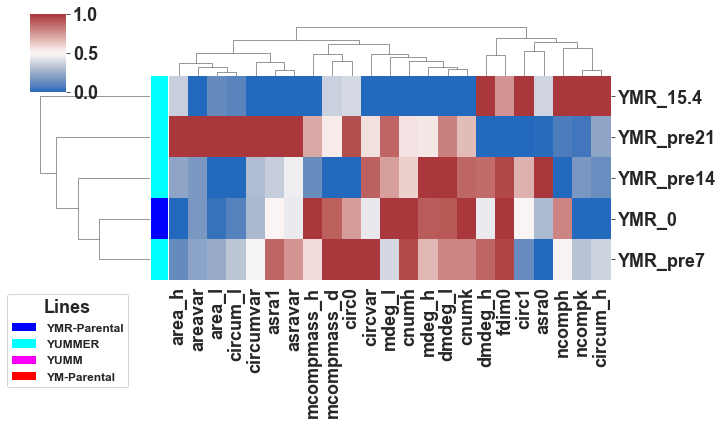

In [19]:
testdf = df_2d.copy(deep=True)

lineages = testdf.pop('lineage')
#testdf.pop('line')
z = np.abs(stats.zscore(testdf))

#threshold = 4
#dropindices = list(dict.fromkeys(np.where(z>threshold)[0].tolist()))
#dropindices = dropindices + [108,125,128,6] #added lineages manually checked and discarded
#print(dropindices)
#testdf = testdf.drop(dropindices)
#lineages = lineages.drop(dropindices)
row_colors = [color_picker(lineage[0])[0] for lineage in df_2d.loc[:,['lineage']].values]
#dropindices.sort(reverse=True)
#for index in dropindices:
#    del row_colors[index]
    
testdf = testdf.reset_index(drop=True)
lineages = lineages.reset_index(drop=True)

YM_indexlist = [i for i in range(len(testdf)) if "YM_" in lineages[i]]
YMR_indexlist = [i for i in range(len(testdf)) if "YMR_" in lineages[i]]

ym_tester = testdf.iloc[YM_indexlist]
ym_lineages = lineages.iloc[YM_indexlist]
ym_colors = [row_colors[i] for i in YM_indexlist]

ymr_tester = testdf.iloc[YMR_indexlist]
ymr_lineages = lineages.iloc[YMR_indexlist]
ymr_colors = [row_colors[i] for i in YMR_indexlist]


g = sns.clustermap(ym_tester,standard_scale=1,row_colors=ym_colors, xticklabels=True,  
                   figsize = (10,6), cmap="vlag",yticklabels=ym_lineages,)

labeler = lambda label : 'YUMMER' if label=='cyan' or label=='navy' else ('YUMM' if label=='magenta' 
                        else ('YMR-Parental' if label=='blue' else('YM-Parental' if label=='red' else 'k')))
for label in np.unique(np.array(row_colors)):
    g.ax_col_dendrogram.bar(0, 0, color=label, label=labeler(label), linewidth=0)
l1 = g.ax_col_dendrogram.legend(title='Lines', loc="center", ncol=1,
            bbox_to_anchor=(-0.23, -5.2),prop={'size': 12})
#plt.title("hierarchical_heatmap_clustering YM SCC")
plt.savefig("hierarchical_heatmap_clustering_YM.svg",format="svg")


g = sns.clustermap(ymr_tester,standard_scale=1,row_colors=ymr_colors, xticklabels=True,  
                   figsize = (10,6), cmap="vlag",yticklabels=ymr_lineages,)

labeler = lambda label : 'YUMMER' if label=='cyan' or label=='navy' else ('YUMM' if label=='magenta' 
                        else ('YMR-Parental' if label=='blue' else('YM-Parental' if label=='red' else 'k')))
for label in np.unique(np.array(row_colors)):
    g.ax_col_dendrogram.bar(0, 0, color=label, label=labeler(label), linewidth=0)
l1 = g.ax_col_dendrogram.legend(title='Lines', loc="center", ncol=1,
            bbox_to_anchor=(-0.23, -5.2),prop={'size': 12})
#plt.title("hierarchical_heatmap_clustering YMR SCC")
plt.savefig("figure_outputs/hierarchical_heatmap_clustering_YMR.svg",format="svg")

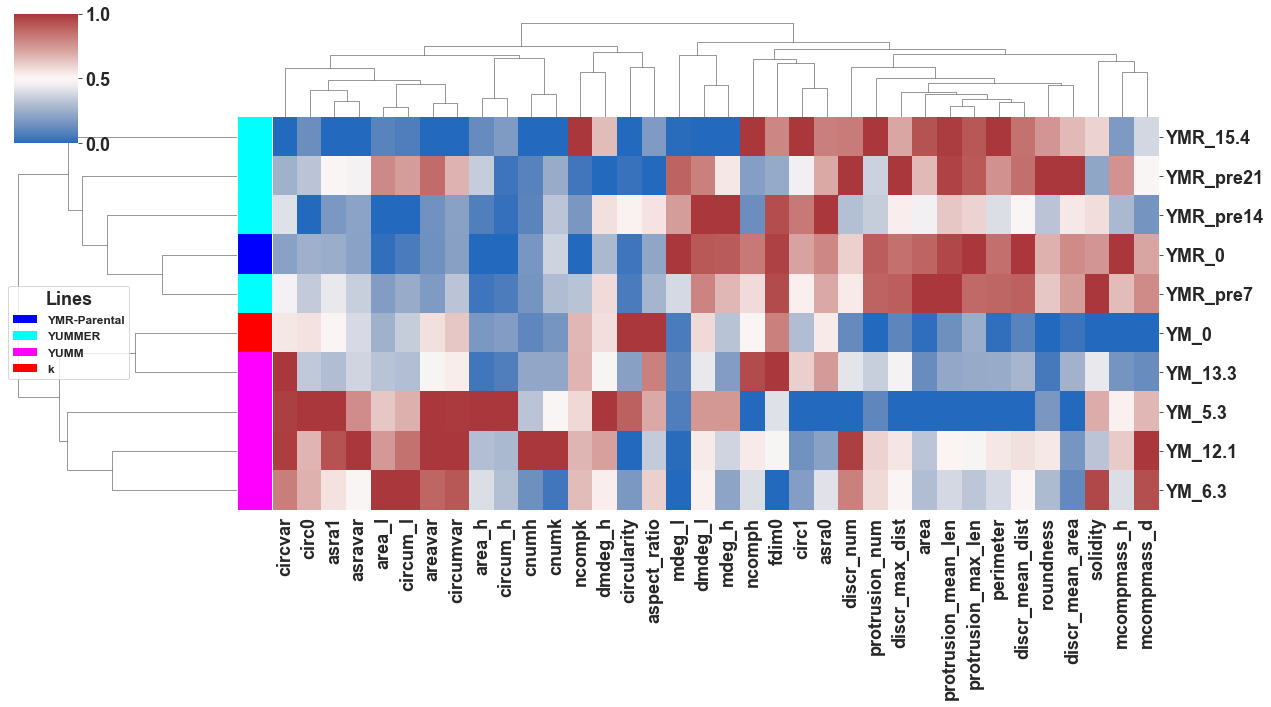

In [25]:
#Hierarchical heatmap clustering:
#Outlier exclusion based on Z-Score Thresholding:

from scipy import stats
#sns.set_theme(color_codes=False)
sns.color_palette("coolwarm", as_cmap=True)

#testdf = df.copy(deep=True)
testdf = combineddf.copy(deep=True)

lineages = testdf.pop('lineage')
#testdf.pop('line')
#z = np.abs(stats.zscore(testdf))

#threshold = 4
#dropindices = list(dict.fromkeys(np.where(z>threshold)[0].tolist()))
#dropindices = dropindices + [108,125,128,6] #added lineages manually checked and discarded
#print(dropindices)
#testdf = testdf.drop(dropindices)
#lineages = lineages.drop(dropindices)
row_colors = [color_picker(lineage[0])[0] for lineage in combineddf.loc[:,['lineage']].values]
#dropindices.sort(reverse=True)
#for index in dropindices:
#    del row_colors[index]

g = sns.clustermap(testdf,standard_scale=1,row_colors=row_colors, xticklabels=True,  
                   figsize = (18,10), cmap="vlag",yticklabels=lineages.iloc[:,0],)


labeler = lambda label : 'YUMMER' if label=='cyan' or label=='navy' else ('YUMM' if label=='magenta' 
                        else ('YMR-Parental' if label=='blue' else('YM-Parental' if label=='yellow' else 'k')))
for label in np.unique(np.array(row_colors)):
    g.ax_col_dendrogram.bar(0, 0, color=label, label=labeler(label), linewidth=0)
l1 = g.ax_col_dendrogram.legend(title='Lines', loc="center", ncol=1,
            bbox_to_anchor=(-0.23, -2.2),prop={'size': 12})

#plt.title("hierarchical heatmap clustering YM+YMR SCC",loc="center")
plt.savefig("figure_outputs/2d3d_hierarchical_heatmap_clustering.svg", format="svg")


In [23]:
testdf = combineddf.copy(deep=True)

lineages = testdf.pop('lineage')
#testdf.pop('line')
z = np.abs(stats.zscore(testdf))

#threshold = 4
#dropindices = list(dict.fromkeys(np.where(z>threshold)[0].tolist()))
#dropindices = dropindices + [108,125,128,6] #added lineages manually checked and discarded
#print(dropindices)
#testdf = testdf.drop(dropindices)
#lineages = lineages.drop(dropindices)
row_colors = [color_picker(lineage[0])[0] for lineage in combineddf.loc[:,['lineage']].values]
#dropindices.sort(reverse=True)
#for index in dropindices:
#    del row_colors[index]
    
testdf = testdf.reset_index(drop=True)
lineages = lineages.reset_index(drop=True)

YM_indexlist = [i for i in range(len(testdf)) if "YM_" in lineages[i]]
YMR_indexlist = [i for i in range(len(testdf)) if "YMR_" in lineages[i]]

ym_tester = testdf.iloc[YM_indexlist]
ym_lineages = lineages.iloc[YM_indexlist]
ym_colors = [row_colors[i] for i in YM_indexlist]

ymr_tester = testdf.iloc[YMR_indexlist]
ymr_lineages = lineages.iloc[YMR_indexlist]
ymr_colors = [row_colors[i] for i in YMR_indexlist]


g = sns.clustermap(ym_tester,standard_scale=1,row_colors=ym_colors, xticklabels=True,  
                   figsize = (10,6), cmap="vlag",yticklabels=ym_lineages,)

labeler = lambda label : 'YUMMER' if label=='cyan' or label=='navy' else ('YUMM' if label=='magenta' 
                        else ('YMR-Parental' if label=='blue' else('YM-Parental' if label=='red' else 'k')))
for label in np.unique(np.array(row_colors)):
    g.ax_col_dendrogram.bar(0, 0, color=label, label=labeler(label), linewidth=0)
l1 = g.ax_col_dendrogram.legend(title='Lines', loc="center", ncol=1,
            bbox_to_anchor=(-0.23, -5.2),prop={'size': 12})
#plt.title("hierarchical_heatmap_clustering YM SCC")
plt.savefig("hierarchical_heatmap_clustering_YM.svg",format="svg")


g = sns.clustermap(ymr_tester,standard_scale=1,row_colors=ymr_colors, xticklabels=True,  
                   figsize = (10,6), cmap="vlag",yticklabels=ymr_lineages,)

labeler = lambda label : 'YUMMER' if label=='cyan' or label=='navy' else ('YUMM' if label=='magenta' 
                        else ('YMR-Parental' if label=='blue' else('YM-Parental' if label=='red' else 'k')))
for label in np.unique(np.array(row_colors)):
    g.ax_col_dendrogram.bar(0, 0, color=label, label=labeler(label), linewidth=0)
l1 = g.ax_col_dendrogram.legend(title='Lines', loc="center", ncol=1,
            bbox_to_anchor=(-0.23, -5.2),prop={'size': 12})
#plt.title("hierarchical_heatmap_clustering YMR SCC")
plt.savefig("figure_outputs/hierarchical_heatmap_clustering_YMR.svg",format="svg")

KeyError: 0

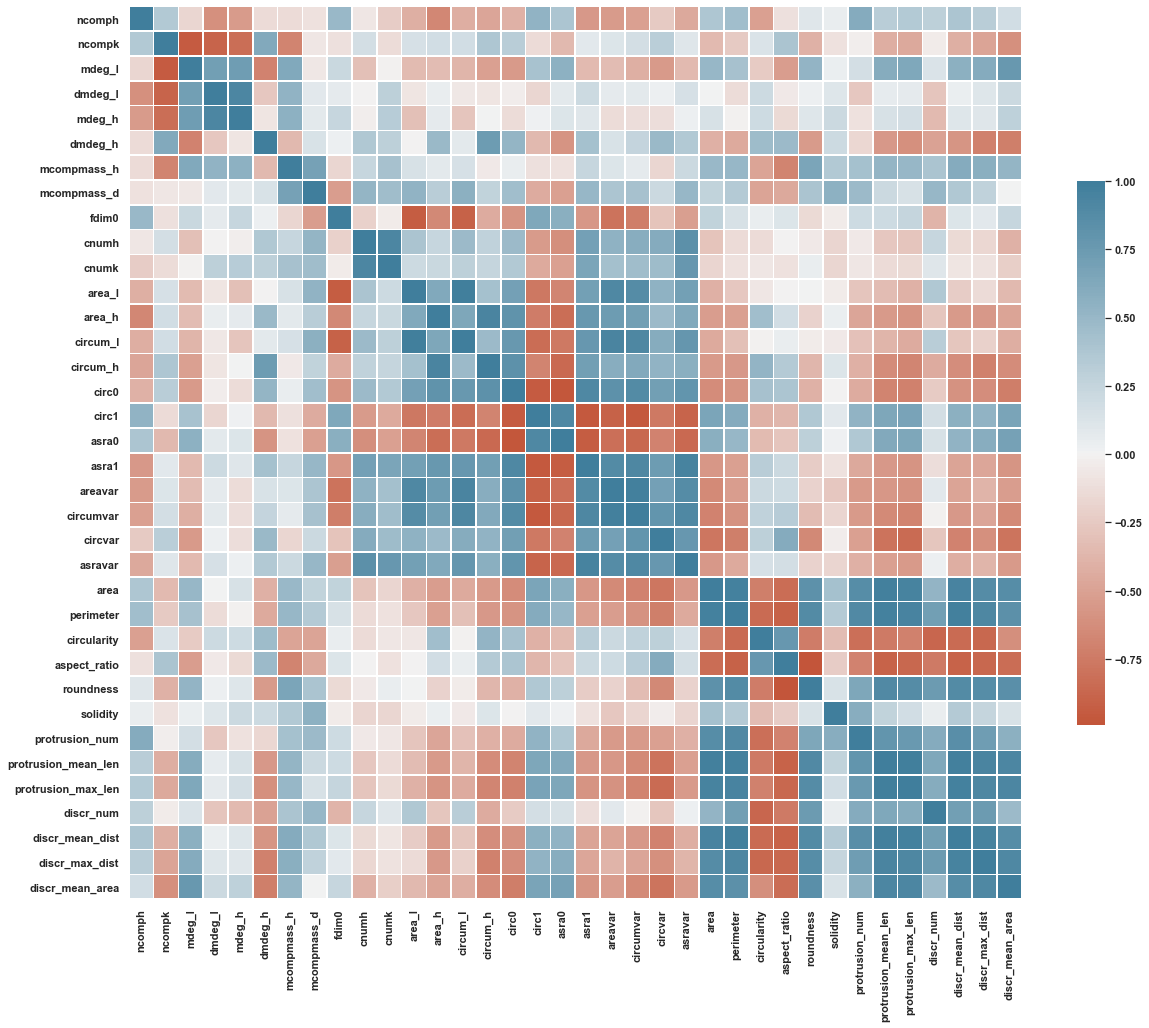

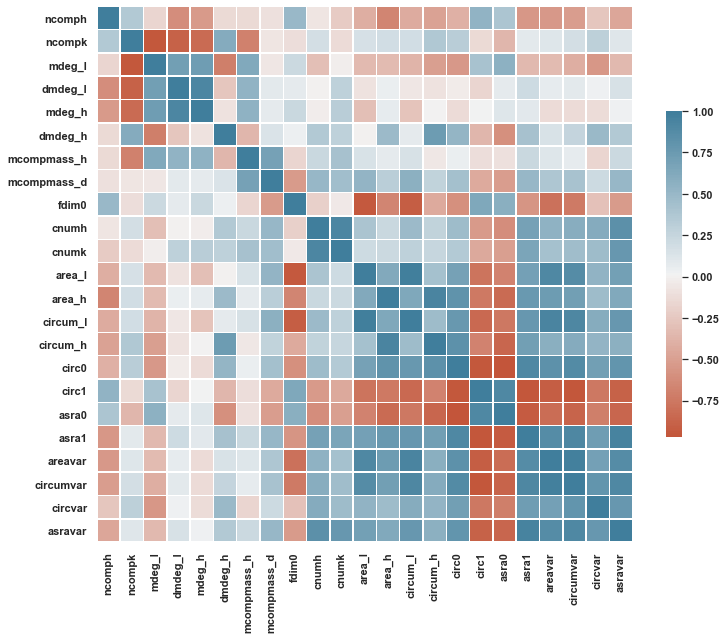

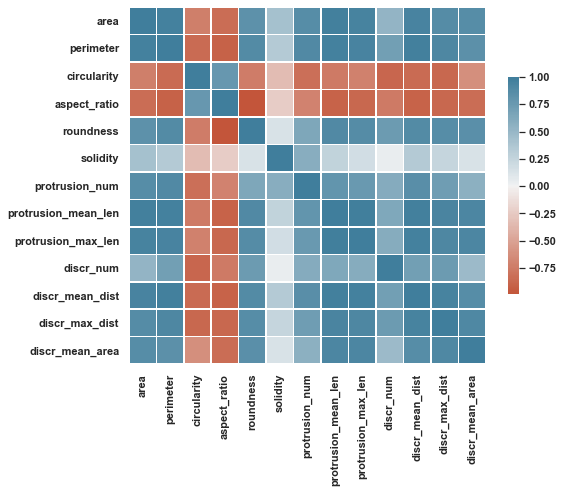

In [117]:
# plot the heatmap
f, ax = plt.subplots(figsize=(20, 20))
g=sns.heatmap(combineddf.corr(), 
           cmap=sns.diverging_palette(20, 230, n=200),
           square=True,
           #xticklabels='True', yticklabels='True'
              cbar_kws={"shrink": .5},
              linewidths=.5
           )
plt.savefig("2d3dCombined_linvar_heatmap.svg", format = 'svg')

# plot the heatmap
f, ax = plt.subplots(figsize=(12, 12))
g=sns.heatmap(df_2d.corr(), 
           cmap=sns.diverging_palette(20, 230, n=200),
           square=True,
           #xticklabels='True', yticklabels='True'
              cbar_kws={"shrink": .5},
              linewidths=.5
           )
plt.savefig("2d_linvar_heatmap.svg", format = 'svg')

# plot the heatmap
f, ax = plt.subplots(figsize=(8, 8))
g=sns.heatmap(df_3d.corr(), 
           cmap=sns.diverging_palette(20, 230, n=200),
           square=True,
           #xticklabels='True', yticklabels='True'
              cbar_kws={"shrink": .5},
              linewidths=.5
           )
plt.savefig("3d_linvar_heatmap.svg", format = 'svg')

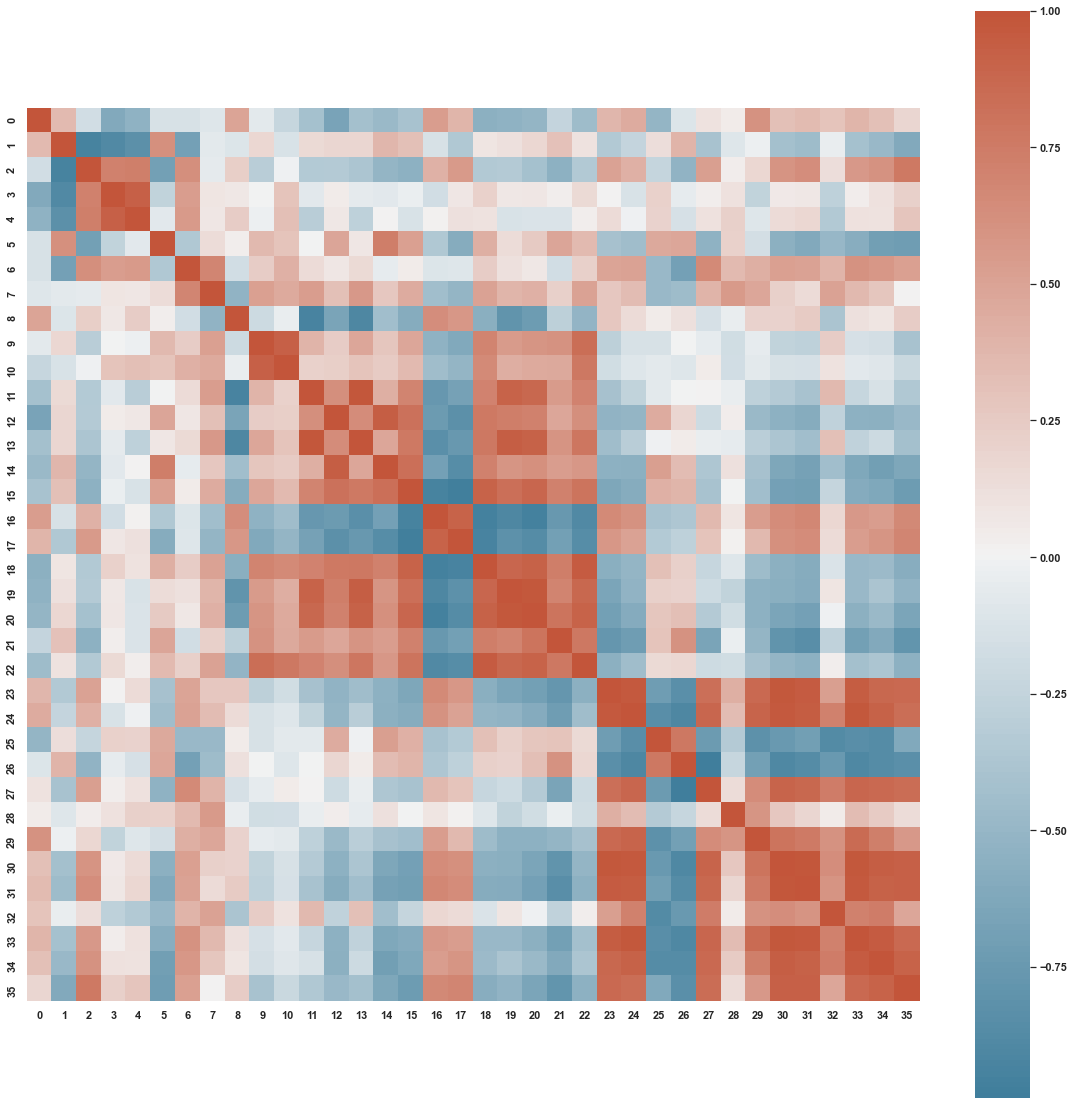

In [109]:
sns.set_theme(style="white")

x = np.corrcoef(x=df_2d,y=df_3d,rowvar=False)
# plot the heatmap
f, ax = plt.subplots(figsize=(20, 20))
g=sns.heatmap(x, 
           cmap=sns.diverging_palette(230, 20, n=200),
           square=True,
           #xticklabels='True', yticklabels='True'
           )
#plt.savefig("2d3dCombined_linvar_heatmap.png", dpi = 75)

In [108]:
combineddf.corr()


,ncomph,ncompk,mdeg_l,dmdeg_l,mdeg_h,dmdeg_h,mcompmass_h,mcompmass_d,fdim0,cnumh,...,aspect_ratio,roundness,solidity,protrusion_num,protrusion_mean_len,protrusion_max_len,discr_num,discr_mean_dist,discr_max_dist,discr_mean_area
ncomph,1.000000,0.359401,-0.172174,-0.607720,-0.536225,-0.142936,-0.140597,-0.103748,0.501656,-0.069519,...,-0.112690,0.101078,0.045526,0.603888,0.313972,0.352178,0.295897,0.384267,0.320523,0.180571
ncompk,0.359401,1.000000,-0.943529,-0.887062,-0.824461,0.615167,-0.689334,-0.073877,-0.111068,0.173316,...,0.396000,-0.395965,-0.097796,-0.023337,-0.426317,-0.457076,-0.038083,-0.419318,-0.490207,-0.608458
mdeg_l,-0.172174,-0.943529,1.000000,0.716890,0.728080,-0.700596,0.629688,-0.057424,0.226606,-0.310829,...,-0.525131,0.532337,0.043603,0.169993,0.592550,0.640477,0.129000,0.563134,0.604803,0.771151
dmdeg_l,-0.607720,-0.887062,0.716890,1.000000,0.923656,-0.255532,0.537082,0.086388,0.073767,0.000234,...,-0.048408,0.034173,0.113990,-0.257435,0.056322,0.073257,-0.279411,0.044396,0.106505,0.223037
mdeg_h,-0.536225,-0.824461,0.728080,0.923656,1.000000,-0.076080,0.554705,0.081923,0.234031,-0.022420,...,-0.146240,0.109560,0.221367,-0.097512,0.151706,0.170800,-0.346458,0.112736,0.097272,0.286314
dmdeg_h,-0.142936,0.615167,-0.700596,-0.255532,-0.076080,1.000000,-0.355220,0.135536,0.033707,0.363591,...,0.475995,-0.534091,0.213743,-0.157814,-0.560791,-0.605551,-0.501110,-0.577451,-0.711153,-0.711991
mcompmass_h,-0.140597,-0.689334,0.629688,0.537082,0.554705,-0.355220,1.000000,0.689163,-0.172775,0.237204,...,-0.690758,0.652207,0.360225,0.423889,0.512996,0.508962,0.396472,0.607232,0.574094,0.515681
mcompmass_d,-0.103748,-0.073877,-0.057424,0.086388,0.081923,0.135536,0.689163,1.000000,-0.522654,0.515323,...,-0.459686,0.398564,0.561167,0.476021,0.218062,0.149753,0.502864,0.366385,0.280227,0.007258
fdim0,0.501656,-0.111068,0.226606,0.073767,0.234031,0.033707,-0.172775,-0.522654,1.000000,-0.195925,...,0.124419,-0.146077,-0.038815,0.199818,0.195196,0.250612,-0.388525,0.120469,0.087057,0.234454
cnumh,-0.069519,0.173316,-0.310829,0.000234,-0.022420,0.363591,0.237204,0.515323,-0.195925,1.000000,...,0.002336,-0.048797,-0.179869,-0.045281,-0.255030,-0.273866,0.235609,-0.153310,-0.161050,-0.402317


In [107]:
df_2d.columns

23

In [106]:
df_3d.columns

13

In [89]:
df_2d.sort_values('lineage',axis = 0)
df_3d.sort_values('lineage',axis = 0)
df_2d.pop('lineage')
df_3d.pop('lineage')
df_2d.corrwith(df_3d,axis=1)

0    YMR_pre14
1     YMR_15.4
2    YMR_pre21
3     YMR_pre7
4        YMR_0
5      YM_12.1
6      YM_13.3
7       YM_5.3
8       YM_6.3
9         YM_0
Name: lineage, dtype: object

In [88]:
df_3d.sort_values('lineage',axis = 0)

,lineage,area,perimeter,circularity,aspect_ratio,roundness,solidity,protrusion_num,protrusion_mean_len,protrusion_max_len,discr_num,discr_mean_dist,discr_max_dist,discr_mean_area
4,YMR_0,0.006377,2.659420,0.011331,1.145573,0.875926,0.495210,69.000000,0.056984,0.075393,51.888889,0.060990,0.116991,0.000004
1,YMR_15.4,0.005994,2.931861,0.009639,1.115540,0.900042,0.427472,75.444444,0.056518,0.077948,73.777778,0.059275,0.101080,0.000004
0,YMR_pre14,0.005736,2.599380,0.010767,1.128865,0.886418,0.453270,70.000000,0.055635,0.081669,56.666667,0.065159,0.112963,0.000004
2,YMR_pre21,0.003418,1.558903,0.023027,1.238818,0.817761,0.423022,38.500000,0.044842,0.062535,33.125000,0.045189,0.085517,0.000004
3,YMR_pre7,0.004534,2.393612,0.010505,1.055381,0.947304,0.363045,39.500000,0.056011,0.077549,88.000000,0.059500,0.125714,0.000005
9,YM_0,0.002538,1.530656,0.014060,1.254021,0.811699,0.488486,51.625000,0.036880,0.049861,73.000000,0.045743,0.083156,0.000003
5,YM_12.1,0.000983,0.672611,0.035300,1.382806,0.754824,0.324662,18.454545,0.028783,0.045857,18.272727,0.029751,0.048868,0.000002
6,YM_13.3,0.002700,1.898824,0.009738,1.169421,0.860442,0.380143,52.714286,0.040824,0.056876,86.285714,0.048324,0.087595,0.000003
7,YM_5.3,0.001606,1.183603,0.014826,1.321113,0.765834,0.399901,38.833333,0.031703,0.045429,42.333333,0.036963,0.080341,0.000003
8,YM_6.3,0.000877,0.618628,0.032557,1.285820,0.787786,0.443292,24.850000,0.024038,0.034049,8.400000,0.025996,0.039715,0.000002
